# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset in Mouse Olfactory Bulb

> **Note**: This notebook was generated with AI assistance. Users should carefully verify all code and interpretations.

## Overview
This Dandiset ([DANDI:001433](https://dandiarchive.org/dandiset/001433/0.250507.2356)) contains behavioral and electrophysiological data from recordings of sniffing, video, and olfactory bulb (OB) local field potentials in freely-behaving mice. The recordings were conducted in the absence of any stimulus, reward, or specific task.

### Dataset Contents
- **Species**: Mus musculus (House mouse)
- **Number of Subjects**: 4 mice
- **Data Types**: 
    - Multi-electrode extracellular electrophysiology (LFP)
    - Behavioral (sniffing)
- **Data Format**: NWB (Neurodata Without Borders)

### This Notebook Covers
1. How to access files using the DANDI API
2. File organization and structure
3. Loading and visualizing LFP data
4. Exploring sniffing signals and breathing events
5. Basic data quality assessment

## Required Packages

In [1]:
import h5py
import pynwb
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

## Dataset Organization
Let's explore how the files are organized in this Dandiset:

In [2]:
# Initialize DANDI client and get dataset
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")

# List all NWB files
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Parse and organize session info
sessions = []
by_subject = defaultdict(list)
for asset in assets:
    parts = asset.path.split('/')
    subject_id = parts[0].replace('sub-', '')
    session = parts[1].split('_')[1]  # extract session timestamp
    sessions.append({
        'subject_id': subject_id,
        'session': session,
        'path': asset.path,
        'size_gb': asset.size / 1e9
    })
    by_subject[subject_id].append(session)

# Display summary
print("Session counts by subject:")
for subject, sessions_list in by_subject.items():
    print(f"Subject {subject}: {len(sessions_list)} sessions")

print("\nExample files:")
pd.DataFrame(sessions[:5])

Session counts by subject:
Subject 4122: 3 sessions
Subject 4127: 9 sessions
Subject 4131: 12 sessions
Subject 4138: 3 sessions

Example files:


,subject_id,session,path,size_gb
0,4122,ses-20250507T152927,sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb,0.268334
1,4122,ses-20250507T152930,sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb,0.329841
2,4122,ses-20250507T152933,sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb,0.408344
3,4127,ses-20250507T152941,sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb,0.492455
4,4127,ses-20250507T152953,sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb,1.056554


## Loading and Exploring a Representative Session

We'll load one session to demonstrate the data structure and content. Note that inhalation and exhalation times in this dataset are stored in milliseconds.

In [3]:
# Load a representative file
file_path = "sub-4131/sub-4131_ses-20250507T153417_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(file_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Visualizing LFP and Sniffing Data

Let's create a comprehensive view of both the LFP and sniffing signals:

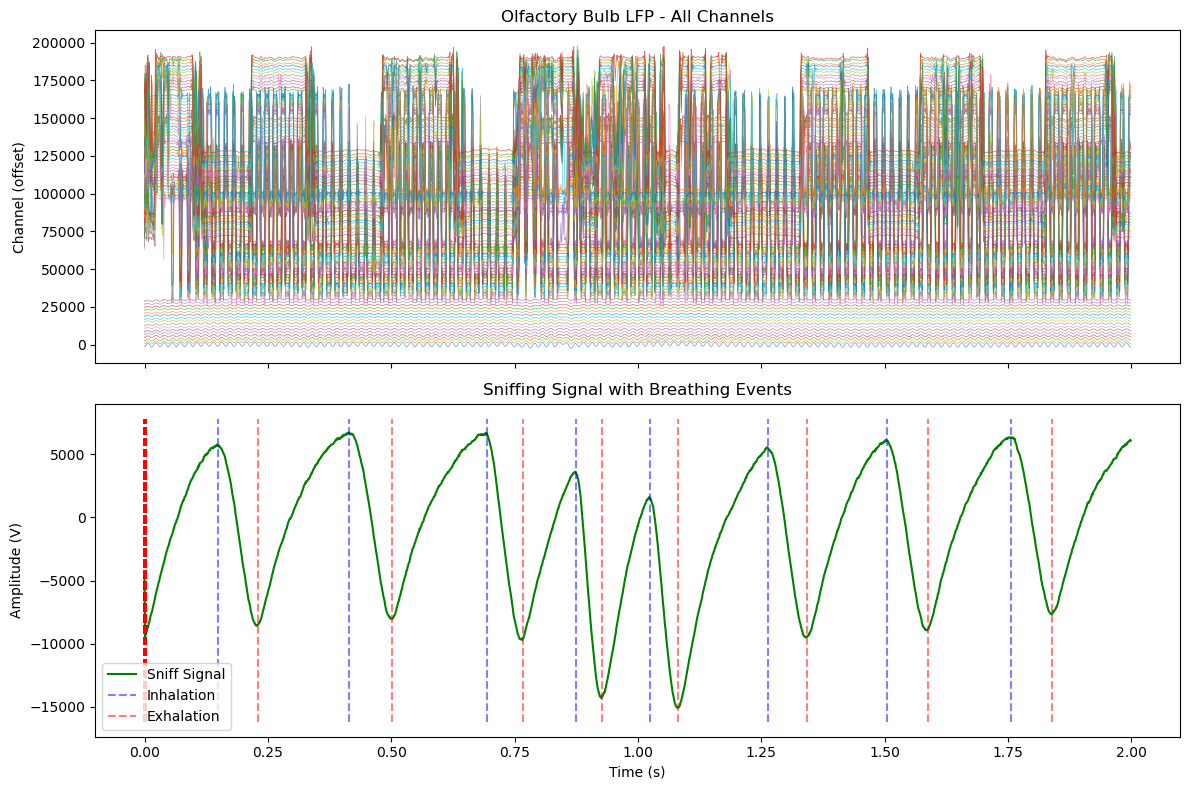

In [4]:
# Extract data
lfp = nwb.acquisition['LFP']
sniff = nwb.acquisition['SniffSignal']
rate = int(lfp.rate)  # Should be 1000 Hz

# Get 2 seconds of data
window_size = 2 * rate
lfp_segment = lfp.data[:window_size, :]  # All channels
sniff_segment = sniff.data[:window_size]
times = np.arange(window_size) / rate

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot LFP (offset channels for visibility)
channel_offsets = np.arange(lfp_segment.shape[1]) * 2000
for i in range(lfp_segment.shape[1]):
    ax1.plot(times, lfp_segment[:, i] + channel_offsets[i], 
             lw=0.5, alpha=0.7)
ax1.set_ylabel('Channel (offset)')
ax1.set_title('Olfactory Bulb LFP - All Channels')

# Plot sniff signal
ax2.plot(times, sniff_segment, 'g-', label='Sniff Signal')

# Get breathing events in this window
inh_times_ms = nwb.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_times_ms = nwb.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]

# Convert to seconds and filter for our window
inh_times_s = inh_times_ms / 1000
exh_times_s = exh_times_ms / 1000
mask_inh = (inh_times_s >= 0) & (inh_times_s <= 2)
mask_exh = (exh_times_s >= 0) & (exh_times_s <= 2)

# Add event markers
ymin, ymax = ax2.get_ylim()
ax2.vlines(inh_times_s[mask_inh], ymin, ymax, 'b', linestyles='dashed', 
           alpha=0.5, label='Inhalation')
ax2.vlines(exh_times_s[mask_exh], ymin, ymax, 'r', linestyles='dashed', 
           alpha=0.5, label='Exhalation')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (V)')
ax2.set_title('Sniffing Signal with Breathing Events')
ax2.legend()

plt.tight_layout()
plt.show()

## Analyzing Breathing Events

Let's examine the timing of breathing events across the session:

In [5]:
# Calculate inter-event intervals
inh_intervals = np.diff(inh_times_ms)  # in milliseconds
exh_intervals = np.diff(exh_times_ms)  # in milliseconds

# Print basic statistics
print("Breathing Event Statistics (ms):")
print(f"Inhalation intervals: mean={np.mean(inh_intervals):.1f}, std={np.std(inh_intervals):.1f}")
print(f"Exhalation intervals: mean={np.mean(exh_intervals):.1f}, std={np.std(exh_intervals):.1f}")
print(f"Number of breathing cycles: {len(inh_times_ms)}")

Breathing Event Statistics (ms):
Inhalation intervals: mean=247.4, std=110.2
Exhalation intervals: mean=-0.0, std=355222.2
Number of breathing cycles: 28475


## Summary of Data Access Methods

Here's a quick reference for accessing different data types in these files:

```python
# LFP data
lfp = nwb.acquisition['LFP']
lfp_data = lfp.data[start:end, channel_num]  # Shape: (time, channels)

# Sniffing signal
sniff = nwb.acquisition['SniffSignal']
sniff_data = sniff.data[start:end]  # Shape: (time,)

# Breathing events (in milliseconds)
inh_times = nwb.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_times = nwb.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]

# Electrode metadata
electrode_info = nwb.electrodes.to_dataframe()
```

## Next Steps

This dataset enables various analyses:
- Investigation of LFP patterns during natural breathing
- Characterization of breathing rhythms
- Cross-subject comparisons of neural activity
- Relationship between breathing phase and LFP oscillations

Consider:
- Quality control across sessions
- Temporal alignment between LFP and breathing events
- Cross-frequency coupling analyses
- Population analyses across subjects